# COVID-19 Lung CT Segmentation & Classification
This notebook aims to build image classifiers to determine whether a paitient is tested positive or negative for COVID-19 based on lung CT scan images. In doing so, a VGG-16 model and a 3-layer CNN model are used for classification.

Prior to the classification, the images are firstly segmented using K-means Clustering to enhance classification performance. Then, the VGG-16 model and the 3-layer CNN model are implemented on the raw and segmented images. The effect of the image segmentation is discussed and two models are compared. To improve the performance of the VGG-16 model, various tuning methods including increasing epochs, changing optimiser and reducing learning rate are performed and evaluated. In addition, pre-trained weights of the VGG-16 model are implemented to enhance the model. 

The dataset is sourced from 'COVID-19 Lung CT Scans' in Kaggle.
https://www.kaggle.com/luisblanche/covidct



## 1. Import libraries

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from skimage.transform import pyramid_reduce, resize
from sklearn.model_selection import train_test_split
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [2]:
np.random.seed(123)

## 2. Pre-processing

In [3]:
# determine extension of images
## covid positive images
path = '../input/covidct/CT_COVID'
ext_set = set()
for child in Path(path).iterdir():
    ext = Path(child).suffix
    ext_set.add(ext)
print(f'positive image extensions: {ext_set}')

## covid negative images
path = '../input/covidct/CT_NonCOVID'
ext_set = set()
for child in Path(path).iterdir():
    ext = Path(child).suffix
    ext_set.add(ext)
print(f'negative image extensions: {ext_set}')

positive image extensions: {'.png'}
negative image extensions: {'.jpg', '.png'}


In [4]:
# obtain list of images
## postive
path = '../input/covidct/CT_COVID'
pos_li = list(Path(path).glob('*.png'))

## negative
path = '../input/covidct/CT_NonCOVID'
neg_li = list(Path(path).glob('*.png'))
neg_li.extend(list(Path(path).glob('*.jpg')))

# display number of images
print(f'Postive images: {len(pos_li)}\nNegative images: {len(neg_li)}')

Postive images: 349
Negative images: 397


In [5]:
# create numpy array placeholder for pixels with 1 channel (grey scale)
IMG_SIZE = 128
pos_data = np.empty((len(pos_li), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
neg_data = np.empty((len(neg_li), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
# ^ float data type must be used to save precise pixel values

In [6]:
# convert images to numpy arrays
## positive
for i, img_path in enumerate(sorted(pos_li)):
    # load image
    img = cv2.imread(str(img_path))
    # convert BGR to RGB (since CV2 reads in BGR)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # resize image with 1 channel
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    # save to x_data
    pos_data[i] = img
## negative
for i, img_path in enumerate(sorted(neg_li)):
    # load image
    img = cv2.imread(str(img_path))
    # convert BGR to RGB (since CV2 reads in BGR)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # resize image with 1 channel
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    # save to x_data
    neg_data[i] = img

In [7]:
# scale image arrays
pos_data /= 255
neg_data /= 255

## 3. Image segmentation with k-means clustering

In [8]:
# define function to perform image segmentation with k-means clustering
def k_means(img_array_list, K, criteria, attempts):
    new_img_array_list = []
    for array in img_array_list:
        # flatten array into 2D
        img = array.reshape(-1,1) # reshape into new dimensions; -1 refers to unknown dimension and will depend on others
                                  # (-1,1) will result in 2D with 1 column and n rows where 1 column x n rows is equal to  
                                  # the original number of elements. ex) (10,10) = (5,20) > both with 100 elements
                                  # 1 column is used since it's gray-scale image (3 used for RGB)
        ret, label, center = cv2.kmeans(img, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
#         center = np.uint8(center)
        res = center[label.flatten()]
        result_image = res.reshape(128,128,1)
        new_img_array_list.append(result_image)
    return new_img_array_list

In [9]:
# perform image segmentation
## define hyperparameters
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
attempts=10
## positive
pos_data_seg = k_means(pos_data, K, criteria, attempts)
## negative
neg_data_seg = k_means(neg_data, K, criteria, attempts)

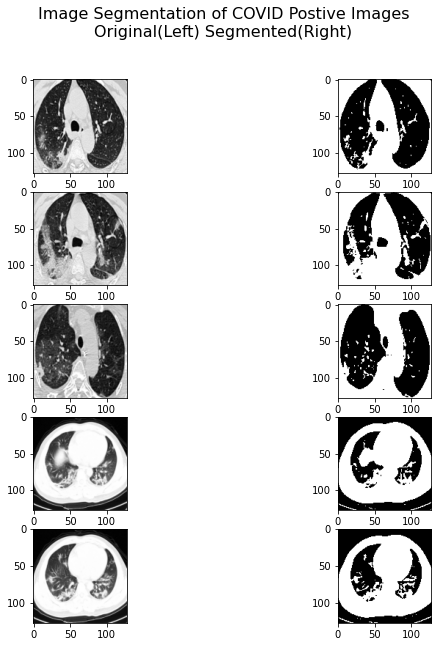

In [10]:
# show results for positive scans
fig, ax = plt.subplots(5, 2, figsize=(10, 10))
for i, seg in enumerate(pos_data_seg):
    if i == 5:
        break
    ax[i, 0].imshow(pos_data[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(seg.squeeze(), cmap='gray')
fig.suptitle('Image Segmentation of COVID Postive Images\nOriginal(Left) Segmented(Right)', fontsize=16)
plt.show()

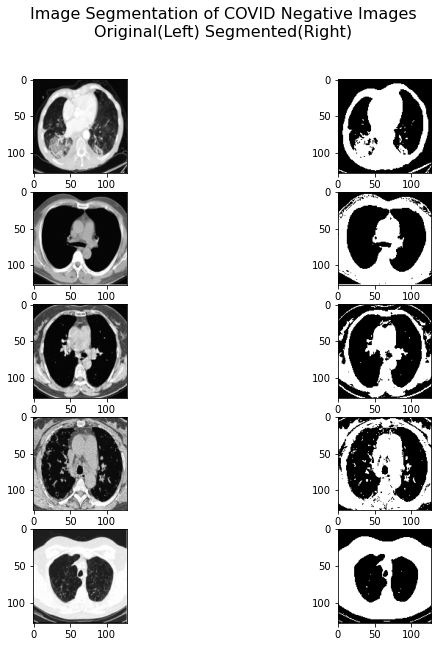

In [11]:
# show results for negtive 
fig, ax = plt.subplots(5, 2, figsize=(10, 10))
for i, seg in enumerate(neg_data_seg):
    if i == 5:
        break
    ax[i, 0].imshow(neg_data[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(seg.squeeze(), cmap='gray')
fig.suptitle('Image Segmentation of COVID Negative Images\nOriginal(Left) Segmented(Right)', fontsize=16)
plt.show()

## 4. Classification using VGG-16 model

In [12]:
# split data into train-validation datasets with 20% validation proportion
x_data = pos_data_seg + neg_data_seg  # segmented images
x_data = np.array(x_data, dtype='float32')

y_data = [1]*len(pos_data_seg) + [0]*len(neg_data_seg)
y_data = np.array(y_data, dtype='float32')

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2)

In [13]:
# callback options
"""
And EarlyStopping will stop the training if validation accuracy doesn't improve in 15 epochs.
"""
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=15, verbose=1, mode='auto')

### 4.1. Classification with segmented images

In [14]:
# define input resolution size
img_height = 128
img_width = 128

# define function to build VGG-16 model
def build_vgg():
    model = Sequential()
    model.add(Conv2D(input_shape=(img_height,img_width,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Flatten())
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=1, activation="sigmoid"))
    opt = Adam(lr=0.001)
    model.compile(optimizer=opt, loss=keras.losses.binary_crossentropy, metrics=['accuracy'])
    
    return model

# build model
model_vgg_seg = build_vgg()

In [15]:
# model summary
model_vgg_seg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       1

In [17]:
# train model
batch_size = 16
epochs = 20
history_vgg_seg = model_vgg_seg.fit(x_train, y_train, validation_data=(x_val, y_val), 
                                    epochs=epochs, batch_size=batch_size, callbacks=[early])

Epoch 1/20
38/38 [==============================] - 3s 70ms/step - loss: 0.7298 - accuracy: 0.5168 - val_loss: 0.6918 - val_accuracy: 0.5267
Epoch 2/20
38/38 [==============================] - 2s 48ms/step - loss: 0.6926 - accuracy: 0.5336 - val_loss: 0.6918 - val_accuracy: 0.5267
Epoch 3/20
38/38 [==============================] - 2s 47ms/step - loss: 0.6918 - accuracy: 0.5336 - val_loss: 0.6917 - val_accuracy: 0.5267
Epoch 4/20
38/38 [==============================] - 2s 47ms/step - loss: 0.6915 - accuracy: 0.5336 - val_loss: 0.6918 - val_accuracy: 0.5267
Epoch 5/20
38/38 [==============================] - 2s 47ms/step - loss: 0.6917 - accuracy: 0.5336 - val_loss: 0.6917 - val_accuracy: 0.5267
Epoch 6/20
38/38 [==============================] - 2s 47ms/step - loss: 0.6916 - accuracy: 0.5336 - val_loss: 0.6919 - val_accuracy: 0.5267
Epoch 7/20
38/38 [==============================] - 2s 48ms/step - loss: 0.6911 - accuracy: 0.5336 - val_loss: 0.6918 - val_accuracy: 0.5267
Epoch 8/20
38

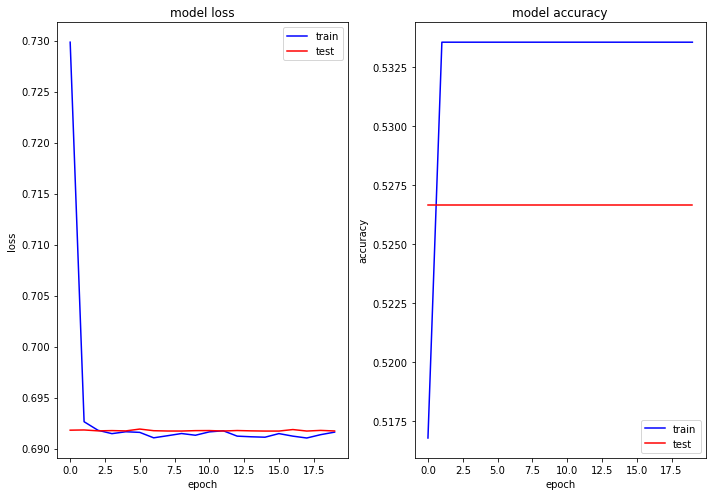

In [18]:
# evaluate model
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

# loss
ax[0].set_title('model loss')
ax[0].plot(history_vgg_seg.history['loss'], 'b')
ax[0].plot(history_vgg_seg.history['val_loss'], 'r')
ax[0].legend(['train', 'test'], loc='upper right')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')

# accuracy 
ax[1].set_title('model accuracy')
ax[1].plot(history_vgg_seg.history['accuracy'], 'b')
ax[1].plot(history_vgg_seg.history['val_accuracy'], 'r')
ax[1].legend(['train', 'test'], loc='lower right')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')

plt.tight_layout()
plt.show()

### 4.2. Classification with raw images

In [19]:
# generate train and validation datasets from directories
"""
https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
https://www.kaggle.com/dergel/cnn-on-covid-19-ct-lungs-scans
"""
DIR = '../input/covidct'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    validation_split=0.2) 

train_generator = train_datagen.flow_from_directory(
    DIR,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode="grayscale",
    subset='training') 

validation_generator = train_datagen.flow_from_directory(
    DIR, 
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode="grayscale",
    subset='validation') 

Found 598 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


In [20]:
# rebuild model
model_vgg_raw = build_vgg()

In [21]:
# train model
history_vgg_raw = model_vgg_raw.fit_generator(train_generator, steps_per_epoch = train_generator.samples // batch_size,
        validation_data = validation_generator, validation_steps = validation_generator.samples // batch_size,
        epochs=epochs, callbacks=[early])

Epoch 1/20
37/37 [==============================] - 7s 190ms/step - loss: 0.7634 - accuracy: 0.5172 - val_loss: 0.6922 - val_accuracy: 0.5278
Epoch 2/20
37/37 [==============================] - 6s 171ms/step - loss: 0.6925 - accuracy: 0.5275 - val_loss: 0.6914 - val_accuracy: 0.5347
Epoch 3/20
37/37 [==============================] - 6s 164ms/step - loss: 0.6921 - accuracy: 0.5361 - val_loss: 0.6899 - val_accuracy: 0.5417
Epoch 4/20
37/37 [==============================] - 6s 163ms/step - loss: 0.6920 - accuracy: 0.5344 - val_loss: 0.6911 - val_accuracy: 0.5347
Epoch 5/20
37/37 [==============================] - 6s 164ms/step - loss: 0.6923 - accuracy: 0.5292 - val_loss: 0.6912 - val_accuracy: 0.5347
Epoch 6/20
37/37 [==============================] - 6s 159ms/step - loss: 0.6927 - accuracy: 0.5309 - val_loss: 0.6918 - val_accuracy: 0.5278
Epoch 7/20
37/37 [==============================] - 6s 167ms/step - loss: 0.6923 - accuracy: 0.5361 - val_loss: 0.6916 - val_accuracy: 0.5278
Epoch 

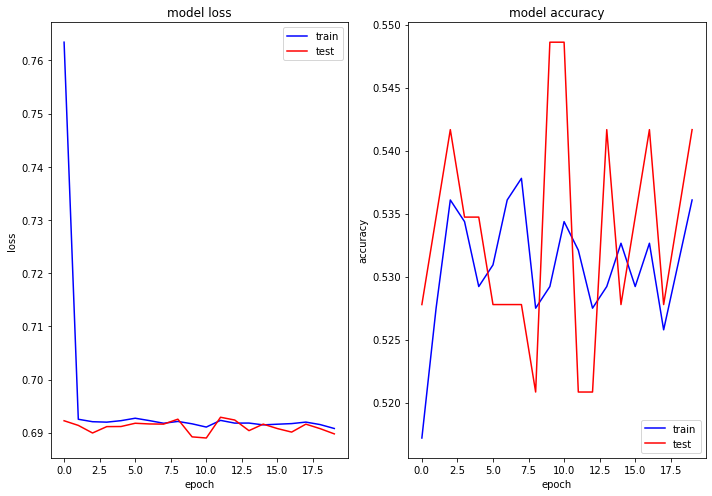

In [22]:
# evaluate model
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

# loss
ax[0].set_title('model loss')
ax[0].plot(history_vgg_raw.history['loss'], 'b')
ax[0].plot(history_vgg_raw.history['val_loss'], 'r')
ax[0].legend(['train', 'test'], loc='upper right')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')

# accuracy 
ax[1].set_title('model accuracy')
ax[1].plot(history_vgg_raw.history['accuracy'], 'b')
ax[1].plot(history_vgg_raw.history['val_accuracy'], 'r')
ax[1].legend(['train', 'test'], loc='lower right')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')

plt.tight_layout()
plt.show()

## 5. Classification using simple 3-layer CNN model

### 5.1. Classification with segmented images

In [23]:
# define function to build 3-layer CNN model
def build_cnn():
    model = Sequential()
    model.add(Conv2D(32, 3, padding='same', activation='relu',input_shape=(img_height, img_width, 1))) 
    model.add(MaxPool2D()) 
    model.add(Conv2D(64, 5, padding='same', activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.001)
    model.compile(optimizer=opt, loss=keras.losses.binary_crossentropy, metrics=['accuracy'])
    
    return model

# build 3-layer CNN model
model_cnn_seg = build_cnn()

In [24]:
model_cnn_seg.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 64, 64, 64)        51264     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8388736   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [25]:
# train model
history_cnn_seg = model_cnn_seg.fit(x_train, y_train, validation_data=(x_val, y_val), 
                                    epochs=epochs, batch_size=batch_size, callbacks=[early])

Epoch 1/20
38/38 [==============================] - 1s 14ms/step - loss: 0.7374 - accuracy: 0.5604 - val_loss: 0.6557 - val_accuracy: 0.6067
Epoch 2/20
38/38 [==============================] - 0s 11ms/step - loss: 0.5943 - accuracy: 0.6913 - val_loss: 0.6016 - val_accuracy: 0.6533
Epoch 3/20
38/38 [==============================] - 0s 11ms/step - loss: 0.4647 - accuracy: 0.7718 - val_loss: 0.6386 - val_accuracy: 0.6267
Epoch 4/20
38/38 [==============================] - 0s 10ms/step - loss: 0.3591 - accuracy: 0.8389 - val_loss: 0.6252 - val_accuracy: 0.7133
Epoch 5/20
38/38 [==============================] - 0s 11ms/step - loss: 0.2764 - accuracy: 0.8909 - val_loss: 0.5666 - val_accuracy: 0.7067
Epoch 6/20
38/38 [==============================] - 0s 10ms/step - loss: 0.1839 - accuracy: 0.9362 - val_loss: 0.7714 - val_accuracy: 0.7133
Epoch 7/20
38/38 [==============================] - 0s 10ms/step - loss: 0.1270 - accuracy: 0.9530 - val_loss: 0.9306 - val_accuracy: 0.6933
Epoch 8/20
38

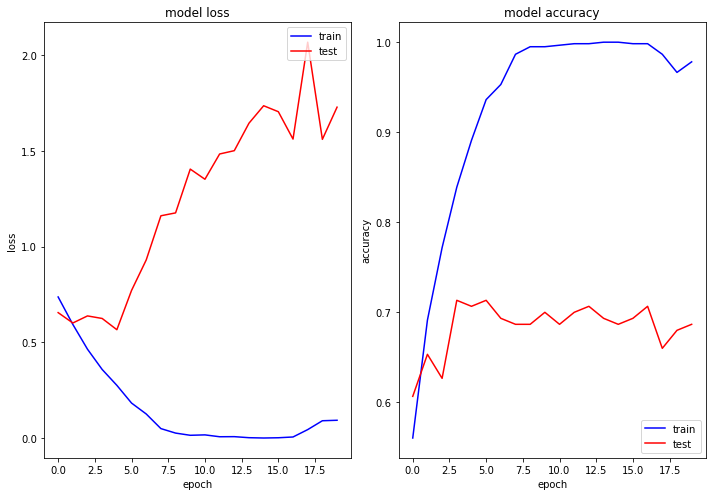

In [26]:
# evaluate model
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

# loss
ax[0].set_title('model loss')
ax[0].plot(history_cnn_seg.history['loss'], 'b')
ax[0].plot(history_cnn_seg.history['val_loss'], 'r')
ax[0].legend(['train', 'test'], loc='upper right')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')

# accuracy 
ax[1].set_title('model accuracy')
ax[1].plot(history_cnn_seg.history['accuracy'], 'b')
ax[1].plot(history_cnn_seg.history['val_accuracy'], 'r')
ax[1].legend(['train', 'test'], loc='lower right')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')

plt.tight_layout()
plt.show()

### 5.2. Classification with raw images

In [27]:
# build model
model_cnn_raw = build_cnn()

In [28]:
history_cnn_raw = model_cnn_raw.fit_generator(train_generator, steps_per_epoch = train_generator.samples // batch_size,
        validation_data = validation_generator, validation_steps = validation_generator.samples // batch_size,
        epochs=epochs, callbacks=[early])

Epoch 1/20
37/37 [==============================] - 6s 171ms/step - loss: 0.7540 - accuracy: 0.5120 - val_loss: 0.6780 - val_accuracy: 0.7292
Epoch 2/20
37/37 [==============================] - 6s 162ms/step - loss: 0.6775 - accuracy: 0.5859 - val_loss: 0.6386 - val_accuracy: 0.7500
Epoch 3/20
37/37 [==============================] - 6s 163ms/step - loss: 0.6546 - accuracy: 0.5979 - val_loss: 0.5570 - val_accuracy: 0.7708
Epoch 4/20
37/37 [==============================] - 6s 154ms/step - loss: 0.6151 - accuracy: 0.6048 - val_loss: 0.5203 - val_accuracy: 0.7639
Epoch 5/20
37/37 [==============================] - 5s 147ms/step - loss: 0.5780 - accuracy: 0.6546 - val_loss: 0.4877 - val_accuracy: 0.7986
Epoch 6/20
37/37 [==============================] - 6s 161ms/step - loss: 0.5690 - accuracy: 0.6787 - val_loss: 0.5303 - val_accuracy: 0.7500
Epoch 7/20
37/37 [==============================] - 5s 147ms/step - loss: 0.5503 - accuracy: 0.7062 - val_loss: 0.4978 - val_accuracy: 0.7917
Epoch 

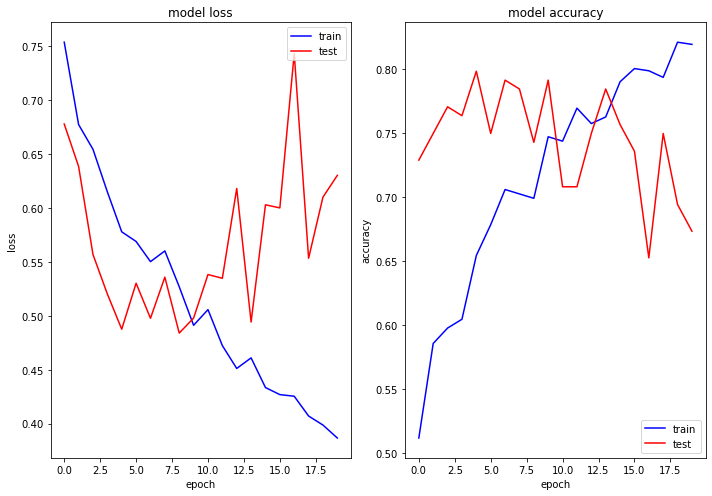

In [30]:
# evaluate model
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

# loss
ax[0].set_title('model loss')
ax[0].plot(history_cnn_raw.history['loss'], 'b')
ax[0].plot(history_cnn_raw.history['val_loss'], 'r')
ax[0].legend(['train', 'test'], loc='upper right')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')

# accuracy 
ax[1].set_title('model accuracy')
ax[1].plot(history_cnn_raw.history['accuracy'], 'b')
ax[1].plot(history_cnn_raw.history['val_accuracy'], 'r')
ax[1].legend(['train', 'test'], loc='lower right')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')

plt.tight_layout()
plt.show()

## 6. Comparison

### Effect of image segmentation
By looking at the performances of the two models on both segmented images and raw images, the image segmentation allows smoother learning for both models reducing variance. And for the 3-layer CNN model, it has reached overfitting quicker with the segmented
images. However, the average validation accuracy for the segmented images is higher than the raw images. This is due to the reduction in image features during image segmentation. Additionally, a stright horizontal line for the validation accuracy of the VGG-16 model on the segmented images indicates that the model predicts the same classes for all iterations. This may be due to a lack of training or incorrect settings for weight initialisation or optimisation. 

### Comparison between deep and simple CNN models
The 3-layer CNN model on both types of images has reached overfitting during training. However, the VGG-16 model did not reach 
overfitting during training. This is likely due to gradient vanishing caused by its deeper architecture. Certainly 20 epochs are
not enough for the gradients to impact the first convolutions of the model. 

Hence, additional epochs and different hyper-parameters are given to the VGG-16 model to enhance its learning. 



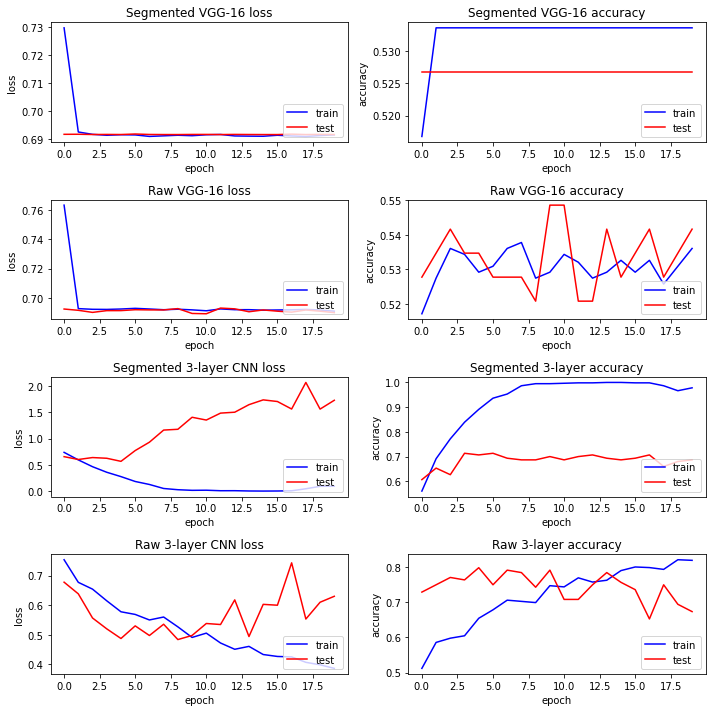

In [33]:
# evaluate model
fig, ax = plt.subplots(4, 2, figsize=(10, 10))

# loss
ax[0,0].set_title('Segmented VGG-16 loss')
ax[0,0].plot(history_vgg_seg.history['loss'], 'b')
ax[0,0].plot(history_vgg_seg.history['val_loss'], 'r')
ax[0,0].legend(['train', 'test'], loc='lower right')
ax[0,0].set_ylabel('loss')
ax[0,0].set_xlabel('epoch')
ax[1,0].set_title('Raw VGG-16 loss')
ax[1,0].plot(history_vgg_raw.history['loss'], 'b')
ax[1,0].plot(history_vgg_raw.history['val_loss'], 'r')
ax[1,0].legend(['train', 'test'], loc='lower right')
ax[1,0].set_ylabel('loss')
ax[1,0].set_xlabel('epoch')
ax[2,0].set_title('Segmented 3-layer CNN loss')
ax[2,0].plot(history_cnn_seg.history['loss'], 'b')
ax[2,0].plot(history_cnn_seg.history['val_loss'], 'r')
ax[2,0].legend(['train', 'test'], loc='lower right')
ax[2,0].set_ylabel('loss')
ax[2,0].set_xlabel('epoch')
ax[3,0].set_title('Raw 3-layer CNN loss')
ax[3,0].plot(history_cnn_raw.history['loss'], 'b')
ax[3,0].plot(history_cnn_raw.history['val_loss'], 'r')
ax[3,0].legend(['train', 'test'], loc='lower right')
ax[3,0].set_ylabel('loss')
ax[3,0].set_xlabel('epoch')

# accuracy 
ax[0,1].set_title('Segmented VGG-16 accuracy')
ax[0,1].plot(history_vgg_seg.history['accuracy'], 'b')
ax[0,1].plot(history_vgg_seg.history['val_accuracy'], 'r')
ax[0,1].legend(['train', 'test'], loc='lower right')
ax[0,1].set_ylabel('accuracy')
ax[0,1].set_xlabel('epoch')
ax[1,1].set_title('Raw VGG-16 accuracy')
ax[1,1].plot(history_vgg_raw.history['accuracy'], 'b')
ax[1,1].plot(history_vgg_raw.history['val_accuracy'], 'r')
ax[1,1].legend(['train', 'test'], loc='lower right')
ax[1,1].set_ylabel('accuracy')
ax[1,1].set_xlabel('epoch')
ax[2,1].set_title('Segmented 3-layer accuracy')
ax[2,1].plot(history_cnn_seg.history['accuracy'], 'b')
ax[2,1].plot(history_cnn_seg.history['val_accuracy'], 'r')
ax[2,1].legend(['train', 'test'], loc='lower right')
ax[2,1].set_ylabel('accuracy')
ax[2,1].set_xlabel('epoch')
ax[3,1].set_title('Raw 3-layer accuracy')
ax[3,1].plot(history_cnn_raw.history['accuracy'], 'b')
ax[3,1].plot(history_cnn_raw.history['val_accuracy'], 'r')
ax[3,1].legend(['train', 'test'], loc='lower right')
ax[3,1].set_ylabel('accuracy')
ax[3,1].set_xlabel('epoch')

plt.tight_layout()
plt.show()

## 7. VGG-16 tuning


### 7.1. VGG-16 with increased epochs

In [34]:
# build vgg-16 model
model_vgg_raw_2 = build_vgg()

In [36]:
# train model
batch_size = 16
epochs = 200
history_vgg_raw_2 = model_vgg_raw_2.fit_generator(train_generator, steps_per_epoch = train_generator.samples // batch_size,
        validation_data = validation_generator, validation_steps = validation_generator.samples // batch_size,
        epochs=epochs, callbacks=[early])

Epoch 1/200
37/37 [==============================] - 6s 152ms/step - loss: 0.6921 - accuracy: 0.5292 - val_loss: 0.6901 - val_accuracy: 0.5417
Epoch 2/200
37/37 [==============================] - 6s 164ms/step - loss: 0.6914 - accuracy: 0.5361 - val_loss: 0.6907 - val_accuracy: 0.5347
Epoch 3/200
37/37 [==============================] - 6s 154ms/step - loss: 0.6922 - accuracy: 0.5309 - val_loss: 0.6908 - val_accuracy: 0.5347
Epoch 4/200
37/37 [==============================] - 6s 160ms/step - loss: 0.6918 - accuracy: 0.5321 - val_loss: 0.6916 - val_accuracy: 0.5278
Epoch 5/200
37/37 [==============================] - 6s 166ms/step - loss: 0.6915 - accuracy: 0.5344 - val_loss: 0.6925 - val_accuracy: 0.5208
Epoch 6/200
37/37 [==============================] - 6s 159ms/step - loss: 0.6912 - accuracy: 0.5361 - val_loss: 0.6916 - val_accuracy: 0.5278
Epoch 7/200
37/37 [==============================] - 6s 168ms/step - loss: 0.6917 - accuracy: 0.5309 - val_loss: 0.6916 - val_accuracy: 0.5278

Epoch 58/200
37/37 [==============================] - 6s 160ms/step - loss: 0.6911 - accuracy: 0.5344 - val_loss: 0.6917 - val_accuracy: 0.5278
Epoch 59/200
37/37 [==============================] - 6s 157ms/step - loss: 0.6917 - accuracy: 0.5326 - val_loss: 0.6916 - val_accuracy: 0.5278
Epoch 60/200
37/37 [==============================] - 6s 161ms/step - loss: 0.6918 - accuracy: 0.5292 - val_loss: 0.6908 - val_accuracy: 0.5347
Epoch 61/200
37/37 [==============================] - 6s 154ms/step - loss: 0.6907 - accuracy: 0.5361 - val_loss: 0.6908 - val_accuracy: 0.5347
Epoch 62/200
37/37 [==============================] - 6s 160ms/step - loss: 0.6920 - accuracy: 0.5309 - val_loss: 0.6900 - val_accuracy: 0.5417
Epoch 63/200
37/37 [==============================] - 6s 155ms/step - loss: 0.6912 - accuracy: 0.5326 - val_loss: 0.6908 - val_accuracy: 0.5347
Epoch 64/200
37/37 [==============================] - 7s 178ms/step - loss: 0.6907 - accuracy: 0.5378 - val_loss: 0.6916 - val_accuracy:

Epoch 115/200
37/37 [==============================] - 6s 158ms/step - loss: 0.6914 - accuracy: 0.5309 - val_loss: 0.6916 - val_accuracy: 0.5278
Epoch 116/200
37/37 [==============================] - 6s 165ms/step - loss: 0.6917 - accuracy: 0.5292 - val_loss: 0.6907 - val_accuracy: 0.5347
Epoch 117/200
37/37 [==============================] - 6s 156ms/step - loss: 0.6914 - accuracy: 0.5309 - val_loss: 0.6908 - val_accuracy: 0.5347
Epoch 118/200
37/37 [==============================] - 6s 160ms/step - loss: 0.6908 - accuracy: 0.5361 - val_loss: 0.6888 - val_accuracy: 0.5486
Epoch 119/200
37/37 [==============================] - 6s 154ms/step - loss: 0.6914 - accuracy: 0.5344 - val_loss: 0.6924 - val_accuracy: 0.5208
Epoch 120/200
37/37 [==============================] - 6s 157ms/step - loss: 0.6918 - accuracy: 0.5292 - val_loss: 0.6907 - val_accuracy: 0.5347
Epoch 121/200
37/37 [==============================] - 6s 159ms/step - loss: 0.6911 - accuracy: 0.5338 - val_loss: 0.6916 - val_ac

37/37 [==============================] - 6s 161ms/step - loss: 0.6913 - accuracy: 0.5309 - val_loss: 0.6908 - val_accuracy: 0.5347
Epoch 172/200
37/37 [==============================] - 6s 157ms/step - loss: 0.6915 - accuracy: 0.5292 - val_loss: 0.6900 - val_accuracy: 0.5417
Epoch 173/200
37/37 [==============================] - 6s 170ms/step - loss: 0.6912 - accuracy: 0.5326 - val_loss: 0.6924 - val_accuracy: 0.5208
Epoch 174/200
37/37 [==============================] - 6s 164ms/step - loss: 0.6913 - accuracy: 0.5309 - val_loss: 0.6924 - val_accuracy: 0.5208
Epoch 175/200
37/37 [==============================] - 6s 156ms/step - loss: 0.6915 - accuracy: 0.5292 - val_loss: 0.6908 - val_accuracy: 0.5347
Epoch 176/200
37/37 [==============================] - 6s 158ms/step - loss: 0.6919 - accuracy: 0.5275 - val_loss: 0.6899 - val_accuracy: 0.5417
Epoch 177/200
37/37 [==============================] - 6s 158ms/step - loss: 0.6914 - accuracy: 0.5292 - val_loss: 0.6916 - val_accuracy: 0.5278

### 7.2. VGG-16 with different optimiser

In [40]:
# build model with SGD instead of ADAM
def build_vgg_sgd():
    model = Sequential()
    model.add(Conv2D(input_shape=(img_height,img_width,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Flatten())
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=1, activation="sigmoid"))
    opt = SGD(lr=0.001)
    model.compile(optimizer=opt, loss=keras.losses.binary_crossentropy, metrics=['accuracy'])
    return model

model_vgg_sgd = build_vgg_sgd()

In [43]:
# train model
batch_size = 16
epochs = 50
history_vgg_sgd = model_vgg_sgd.fit_generator(train_generator, steps_per_epoch = train_generator.samples // batch_size,
        validation_data = validation_generator, validation_steps = validation_generator.samples // batch_size,
        epochs=epochs, callbacks=[early])

Epoch 1/50
37/37 [==============================] - 6s 152ms/step - loss: 0.6930 - accuracy: 0.5338 - val_loss: 0.6929 - val_accuracy: 0.5347
Epoch 2/50
37/37 [==============================] - 6s 163ms/step - loss: 0.6929 - accuracy: 0.5326 - val_loss: 0.6928 - val_accuracy: 0.5417
Epoch 3/50
37/37 [==============================] - 6s 150ms/step - loss: 0.6928 - accuracy: 0.5378 - val_loss: 0.6927 - val_accuracy: 0.5417
Epoch 4/50
37/37 [==============================] - 6s 160ms/step - loss: 0.6928 - accuracy: 0.5292 - val_loss: 0.6926 - val_accuracy: 0.5417
Epoch 5/50
37/37 [==============================] - 6s 169ms/step - loss: 0.6926 - accuracy: 0.5326 - val_loss: 0.6925 - val_accuracy: 0.5417
Epoch 6/50
37/37 [==============================] - 6s 163ms/step - loss: 0.6927 - accuracy: 0.5292 - val_loss: 0.6927 - val_accuracy: 0.5278
Epoch 7/50
37/37 [==============================] - 6s 160ms/step - loss: 0.6924 - accuracy: 0.5361 - val_loss: 0.6925 - val_accuracy: 0.5347
Epoch 

### 7.3. VGG-16 with reduced learning rate

In [44]:
# build model with SGD reduced learning rate
def build_vgg_sgd2():
    model = Sequential()
    model.add(Conv2D(input_shape=(img_height,img_width,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Flatten())
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=1, activation="sigmoid"))
    opt = SGD(lr=1e-5)
    model.compile(optimizer=opt, loss=keras.losses.binary_crossentropy, metrics=['accuracy'])
    return model

model_vgg_sgd2 = build_vgg_sgd2()

In [56]:
# train model
batch_size = 16
epochs = 200
history_vgg_sgd2 = model_vgg_sgd2.fit_generator(train_generator, steps_per_epoch = train_generator.samples // batch_size,
        validation_data = validation_generator, validation_steps = validation_generator.samples // batch_size,
        epochs=epochs, callbacks=[early])

Epoch 1/200
37/37 [==============================] - 6s 166ms/step - loss: 0.6931 - accuracy: 0.5309 - val_loss: 0.6931 - val_accuracy: 0.5347
Epoch 2/200
37/37 [==============================] - 6s 159ms/step - loss: 0.6931 - accuracy: 0.5344 - val_loss: 0.6931 - val_accuracy: 0.5486
Epoch 3/200
37/37 [==============================] - 6s 167ms/step - loss: 0.6931 - accuracy: 0.5275 - val_loss: 0.6931 - val_accuracy: 0.5486
Epoch 4/200
37/37 [==============================] - 6s 165ms/step - loss: 0.6931 - accuracy: 0.5275 - val_loss: 0.6931 - val_accuracy: 0.5347
Epoch 5/200
37/37 [==============================] - 6s 168ms/step - loss: 0.6931 - accuracy: 0.5326 - val_loss: 0.6931 - val_accuracy: 0.5417
Epoch 6/200
37/37 [==============================] - 7s 188ms/step - loss: 0.6931 - accuracy: 0.5326 - val_loss: 0.6931 - val_accuracy: 0.5417
Epoch 7/200
37/37 [==============================] - 6s 167ms/step - loss: 0.6931 - accuracy: 0.5326 - val_loss: 0.6931 - val_accuracy: 0.5278

Epoch 58/200
37/37 [==============================] - 6s 172ms/step - loss: 0.6930 - accuracy: 0.5309 - val_loss: 0.6930 - val_accuracy: 0.5486
Epoch 59/200
37/37 [==============================] - 6s 163ms/step - loss: 0.6930 - accuracy: 0.5309 - val_loss: 0.6931 - val_accuracy: 0.5278
Epoch 60/200
37/37 [==============================] - 6s 170ms/step - loss: 0.6930 - accuracy: 0.5275 - val_loss: 0.6930 - val_accuracy: 0.5347
Epoch 61/200
37/37 [==============================] - 7s 185ms/step - loss: 0.6930 - accuracy: 0.5361 - val_loss: 0.6930 - val_accuracy: 0.5347
Epoch 62/200
37/37 [==============================] - 7s 179ms/step - loss: 0.6931 - accuracy: 0.5241 - val_loss: 0.6930 - val_accuracy: 0.5347
Epoch 63/200
37/37 [==============================] - 7s 180ms/step - loss: 0.6930 - accuracy: 0.5309 - val_loss: 0.6930 - val_accuracy: 0.5347
Epoch 64/200
37/37 [==============================] - 6s 167ms/step - loss: 0.6930 - accuracy: 0.5326 - val_loss: 0.6930 - val_accuracy:

Epoch 115/200
37/37 [==============================] - 7s 180ms/step - loss: 0.6930 - accuracy: 0.5344 - val_loss: 0.6930 - val_accuracy: 0.5208
Epoch 116/200
37/37 [==============================] - 7s 186ms/step - loss: 0.6930 - accuracy: 0.5309 - val_loss: 0.6930 - val_accuracy: 0.5208
Epoch 117/200
37/37 [==============================] - 6s 173ms/step - loss: 0.6930 - accuracy: 0.5292 - val_loss: 0.6930 - val_accuracy: 0.5347
Epoch 118/200
37/37 [==============================] - 7s 176ms/step - loss: 0.6930 - accuracy: 0.5344 - val_loss: 0.6930 - val_accuracy: 0.5278
Epoch 119/200
37/37 [==============================] - 7s 179ms/step - loss: 0.6930 - accuracy: 0.5361 - val_loss: 0.6930 - val_accuracy: 0.5208
Epoch 120/200
37/37 [==============================] - 6s 171ms/step - loss: 0.6930 - accuracy: 0.5292 - val_loss: 0.6930 - val_accuracy: 0.5347
Epoch 121/200
37/37 [==============================] - 7s 177ms/step - loss: 0.6930 - accuracy: 0.5326 - val_loss: 0.6930 - val_ac

37/37 [==============================] - 7s 180ms/step - loss: 0.6929 - accuracy: 0.5292 - val_loss: 0.6930 - val_accuracy: 0.5278
Epoch 172/200
37/37 [==============================] - 6s 161ms/step - loss: 0.6929 - accuracy: 0.5292 - val_loss: 0.6930 - val_accuracy: 0.5208
Epoch 173/200
37/37 [==============================] - 6s 173ms/step - loss: 0.6929 - accuracy: 0.5361 - val_loss: 0.6929 - val_accuracy: 0.5347
Epoch 174/200
37/37 [==============================] - 6s 165ms/step - loss: 0.6929 - accuracy: 0.5344 - val_loss: 0.6930 - val_accuracy: 0.5208
Epoch 175/200
37/37 [==============================] - 6s 170ms/step - loss: 0.6929 - accuracy: 0.5292 - val_loss: 0.6930 - val_accuracy: 0.5278
Epoch 176/200
37/37 [==============================] - 6s 161ms/step - loss: 0.6929 - accuracy: 0.5361 - val_loss: 0.6929 - val_accuracy: 0.5347
Epoch 177/200
37/37 [==============================] - 6s 169ms/step - loss: 0.6929 - accuracy: 0.5275 - val_loss: 0.6929 - val_accuracy: 0.5417

### 7.4. Evaluations
VGG-16 model is tuned by increasing epochs, chaning optimiser and reducing learning rate. Purely increasing epochs to 200 did not show any effect on the model's learning. The oscillation in both loss and accuracy indicates that the model still cannot learn the image feauters. Thus, different approaches are used. Chaning the optimiser from ADAM to SDG and reducing the learning rate showed enhancement in the model's learning implied by the continuously decreasing training and testing loss. However, the reduction rate is marginal so that the accuracy is still fluctuating. Considering the size of the available dataset with about 600 images, training a deep architectural neural network such as VGG-16 may be limited. Thus, pre-trained VGG-16 model is loaded to benefit from the pre-trained weights and to examine its ability in learning the image features. 

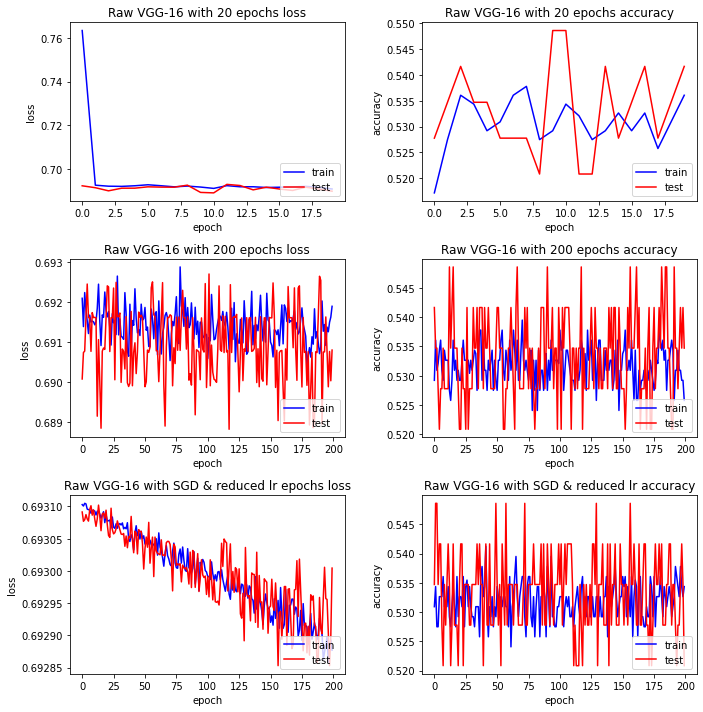

In [64]:
# evaluate model
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

# loss
ax[0,0].set_title('Raw VGG-16 with 20 epochs loss')
ax[0,0].plot(history_vgg_raw.history['loss'], 'b')
ax[0,0].plot(history_vgg_raw.history['val_loss'], 'r')
ax[0,0].legend(['train', 'test'], loc='lower right')
ax[0,0].set_ylabel('loss')
ax[0,0].set_xlabel('epoch')
ax[1,0].set_title('Raw VGG-16 with 200 epochs loss')
ax[1,0].plot(history_vgg_raw_2.history['loss'], 'b')
ax[1,0].plot(history_vgg_raw_2.history['val_loss'], 'r')
ax[1,0].legend(['train', 'test'], loc='lower right')
ax[1,0].set_ylabel('loss')
ax[1,0].set_xlabel('epoch')
ax[2,0].set_title('Raw VGG-16 with SGD & reduced lr epochs loss')
ax[2,0].plot(history_vgg_sgd2.history['loss'], 'b')
ax[2,0].plot(history_vgg_sgd2.history['val_loss'], 'r')
ax[2,0].legend(['train', 'test'], loc='lower right')
ax[2,0].set_ylabel('loss')
ax[2,0].set_xlabel('epoch')

# accuracy 
ax[0,1].set_title('Raw VGG-16 with 20 epochs accuracy')
ax[0,1].plot(history_vgg_raw.history['accuracy'], 'b')
ax[0,1].plot(history_vgg_raw.history['val_accuracy'], 'r')
ax[0,1].legend(['train', 'test'], loc='lower right')
ax[0,1].set_ylabel('accuracy')
ax[0,1].set_xlabel('epoch')
ax[1,1].set_title('Raw VGG-16 with 200 epochs accuracy')
ax[1,1].plot(history_vgg_raw_2.history['accuracy'], 'b')
ax[1,1].plot(history_vgg_raw_2.history['val_accuracy'], 'r')
ax[1,1].legend(['train', 'test'], loc='lower right')
ax[1,1].set_ylabel('accuracy')
ax[1,1].set_xlabel('epoch')
ax[2,1].set_title('Raw VGG-16 with SGD & reduced lr accuracy')
ax[2,1].plot(history_vgg_sgd2.history['accuracy'], 'b')
ax[2,1].plot(history_vgg_sgd2.history['val_accuracy'], 'r')
ax[2,1].legend(['train', 'test'], loc='lower right')
ax[2,1].set_ylabel('accuracy')
ax[2,1].set_xlabel('epoch')

plt.tight_layout()
plt.show()

## 8. Pre-trained VGG-16 

In [129]:
# load pre-trained model
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

# load model without classifier layers
vgg = VGG16(include_top=False, input_shape=(128, 128, 3), weights='imagenet', pooling='avg')
# make only last 2 conv layers trainable
for layer in vgg.layers[:-4]:
    layer.trainable = False
# add output layer 
out_layer = Dense(1, activation='sigmoid')(vgg.layers[-1].output)
model_pre_vgg = Model(vgg.input, out_layer)
# compile model
opt = SGD(lr=1e-5)
model_pre_vgg.compile(optimizer=opt, loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [123]:
# model summary
model_pre_vgg.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [130]:
# load images in RGB-scale without normalisation
train_datagen_pre_vgg = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    validation_split=0.2) 

train_generator_pre_vgg = train_datagen_pre_vgg.flow_from_directory(
    DIR,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode="rgb",
    subset='training') 

validation_generator_pre_vgg = train_datagen_pre_vgg.flow_from_directory(
    DIR, 
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode="rgb",
    subset='validation') 

Found 598 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


In [131]:
# train model
batch_size = 16
epochs = 200
history_pre_vgg = model_pre_vgg.fit_generator(train_generator_pre_vgg, steps_per_epoch = train_generator_pre_vgg.samples // batch_size,
        validation_data = validation_generator_pre_vgg, validation_steps = validation_generator_pre_vgg.samples // batch_size,
        epochs=epochs, callbacks=[early])

Epoch 1/200
37/37 [==============================] - 8s 224ms/step - loss: 2.4012 - accuracy: 0.4863 - val_loss: 1.4399 - val_accuracy: 0.7014
Epoch 2/200
37/37 [==============================] - 8s 212ms/step - loss: 1.9289 - accuracy: 0.5189 - val_loss: 1.0046 - val_accuracy: 0.7500
Epoch 3/200
37/37 [==============================] - 8s 207ms/step - loss: 1.7078 - accuracy: 0.5447 - val_loss: 1.0805 - val_accuracy: 0.7292
Epoch 4/200
37/37 [==============================] - 8s 214ms/step - loss: 1.5075 - accuracy: 0.5773 - val_loss: 0.9893 - val_accuracy: 0.7847
Epoch 5/200
37/37 [==============================] - 8s 208ms/step - loss: 1.4177 - accuracy: 0.5619 - val_loss: 1.0468 - val_accuracy: 0.7361
Epoch 6/200
37/37 [==============================] - 8s 203ms/step - loss: 1.3049 - accuracy: 0.6048 - val_loss: 1.0230 - val_accuracy: 0.7500
Epoch 7/200
37/37 [==============================] - 8s 216ms/step - loss: 1.2450 - accuracy: 0.6048 - val_loss: 0.8317 - val_accuracy: 0.7431

Epoch 58/200
37/37 [==============================] - 8s 208ms/step - loss: 0.4882 - accuracy: 0.8144 - val_loss: 0.5897 - val_accuracy: 0.7569
Epoch 59/200
37/37 [==============================] - 8s 216ms/step - loss: 0.4564 - accuracy: 0.8110 - val_loss: 0.5058 - val_accuracy: 0.7986
Epoch 60/200
37/37 [==============================] - 8s 229ms/step - loss: 0.4509 - accuracy: 0.7990 - val_loss: 0.6093 - val_accuracy: 0.7847
Epoch 61/200
37/37 [==============================] - 8s 209ms/step - loss: 0.4263 - accuracy: 0.8144 - val_loss: 0.6122 - val_accuracy: 0.7431
Epoch 62/200
37/37 [==============================] - 8s 204ms/step - loss: 0.4830 - accuracy: 0.7749 - val_loss: 0.6578 - val_accuracy: 0.7431
Epoch 63/200
37/37 [==============================] - 7s 202ms/step - loss: 0.4410 - accuracy: 0.8076 - val_loss: 0.5735 - val_accuracy: 0.7431
Epoch 64/200
37/37 [==============================] - 8s 205ms/step - loss: 0.3980 - accuracy: 0.8436 - val_loss: 0.6944 - val_accuracy:

Epoch 115/200
37/37 [==============================] - 8s 208ms/step - loss: 0.3033 - accuracy: 0.8643 - val_loss: 0.6289 - val_accuracy: 0.7500
Epoch 116/200
37/37 [==============================] - 7s 196ms/step - loss: 0.2757 - accuracy: 0.8900 - val_loss: 0.6419 - val_accuracy: 0.7431
Epoch 117/200
37/37 [==============================] - 7s 202ms/step - loss: 0.2975 - accuracy: 0.8780 - val_loss: 0.6340 - val_accuracy: 0.7431
Epoch 118/200
37/37 [==============================] - 8s 203ms/step - loss: 0.3008 - accuracy: 0.8505 - val_loss: 0.5749 - val_accuracy: 0.7639
Epoch 119/200
37/37 [==============================] - 8s 205ms/step - loss: 0.2488 - accuracy: 0.8866 - val_loss: 0.5803 - val_accuracy: 0.7569
Epoch 120/200
37/37 [==============================] - 8s 206ms/step - loss: 0.3051 - accuracy: 0.8660 - val_loss: 0.5960 - val_accuracy: 0.7569
Epoch 121/200
37/37 [==============================] - 8s 219ms/step - loss: 0.3091 - accuracy: 0.8763 - val_loss: 0.5862 - val_ac

37/37 [==============================] - 8s 204ms/step - loss: 0.2637 - accuracy: 0.8900 - val_loss: 0.6679 - val_accuracy: 0.7778
Epoch 172/200
37/37 [==============================] - 8s 203ms/step - loss: 0.2248 - accuracy: 0.9021 - val_loss: 0.6791 - val_accuracy: 0.7778
Epoch 173/200
37/37 [==============================] - 8s 207ms/step - loss: 0.2462 - accuracy: 0.8952 - val_loss: 0.6488 - val_accuracy: 0.7708
Epoch 174/200
37/37 [==============================] - 8s 215ms/step - loss: 0.2265 - accuracy: 0.9072 - val_loss: 0.6670 - val_accuracy: 0.7292
Epoch 175/200
37/37 [==============================] - 8s 212ms/step - loss: 0.2631 - accuracy: 0.8883 - val_loss: 0.8001 - val_accuracy: 0.6736
Epoch 176/200
37/37 [==============================] - 8s 204ms/step - loss: 0.2098 - accuracy: 0.9175 - val_loss: 0.6642 - val_accuracy: 0.7222
Epoch 177/200
37/37 [==============================] - 8s 205ms/step - loss: 0.2071 - accuracy: 0.9089 - val_loss: 0.6434 - val_accuracy: 0.7569

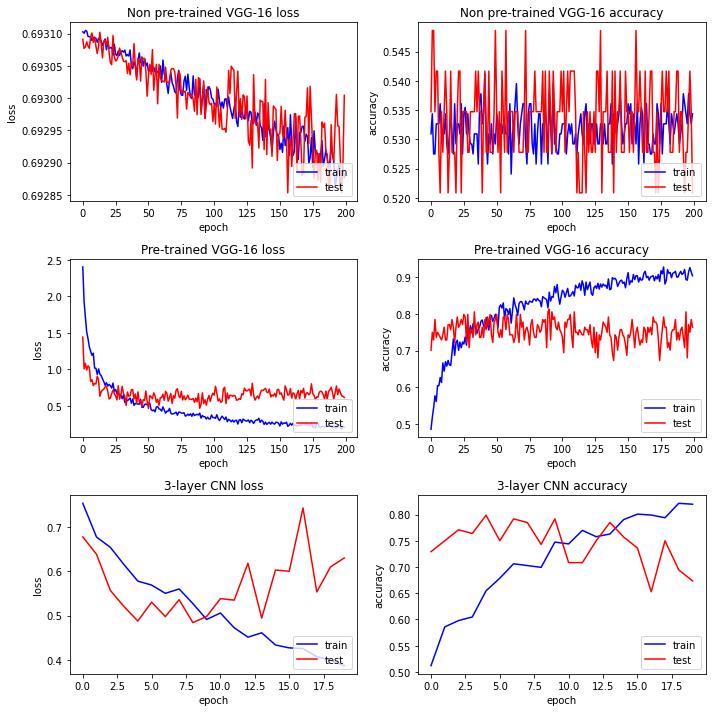

In [135]:
# evaluate model
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

# loss
ax[0,0].set_title('Non pre-trained VGG-16 loss')
ax[0,0].plot(history_vgg_sgd2.history['loss'], 'b')
ax[0,0].plot(history_vgg_sgd2.history['val_loss'], 'r')
ax[0,0].legend(['train', 'test'], loc='lower right')
ax[0,0].set_ylabel('loss')
ax[0,0].set_xlabel('epoch')
ax[1,0].set_title('Pre-trained VGG-16 loss')
ax[1,0].plot(history_pre_vgg.history['loss'], 'b')
ax[1,0].plot(history_pre_vgg.history['val_loss'], 'r')
ax[1,0].legend(['train', 'test'], loc='lower right')
ax[1,0].set_ylabel('loss')
ax[1,0].set_xlabel('epoch')
ax[2,0].set_title('3-layer CNN loss')
ax[2,0].plot(history_cnn_raw.history['loss'], 'b')
ax[2,0].plot(history_cnn_raw.history['val_loss'], 'r')
ax[2,0].legend(['train', 'test'], loc='lower right')
ax[2,0].set_ylabel('loss')
ax[2,0].set_xlabel('epoch')


# accuracy 
ax[0,1].set_title('Non pre-trained VGG-16 accuracy')
ax[0,1].plot(history_vgg_sgd2.history['accuracy'], 'b')
ax[0,1].plot(history_vgg_sgd2.history['val_accuracy'], 'r')
ax[0,1].legend(['train', 'test'], loc='lower right')
ax[0,1].set_ylabel('accuracy')
ax[0,1].set_xlabel('epoch')
ax[1,1].set_title('Pre-trained VGG-16 accuracy')
ax[1,1].plot(history_pre_vgg.history['accuracy'], 'b')
ax[1,1].plot(history_pre_vgg.history['val_accuracy'], 'r')
ax[1,1].legend(['train', 'test'], loc='lower right')
ax[1,1].set_ylabel('accuracy')
ax[1,1].set_xlabel('epoch')
ax[2,1].set_title('3-layer CNN accuracy')
ax[2,1].plot(history_cnn_raw.history['accuracy'], 'b')
ax[2,1].plot(history_cnn_raw.history['val_accuracy'], 'r')
ax[2,1].legend(['train', 'test'], loc='lower right')
ax[2,1].set_ylabel('accuracy')
ax[2,1].set_xlabel('epoch')


plt.tight_layout()
plt.show()

### 8.1. Evaluations

Implementing the pre-trained VGG-16 model significantly improved the learning ability of the model. It reaches overfitting at around 25 epochs and its accuracy ranges between 0.7 to 0.8. This is because the pre-trained model has weights that are already trained on large set of images. Only the last two convolutional layers of the model are trained in order to learn the features of the lung CT scan images. By using the pre-trained weights, the model overcame the limitation of its deep architecture and the small datasets. 

In comparison to the 3-layer CNN model, the testing accuracies are similar ranging between 0.7 and 0.8. This may be due to the limitation of the learnable features from the small datasets. Hence, using a simple model may be a good decision in this case for the sake of computation time and resources. For future application, increasing dataset size by data augmentation can be looked into to fully achieve the potential of the deep architectural neural networks. 